In [1]:
import random
from tensorflow.python.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.callbacks import ModelCheckpoint


import numpy as np

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

import h5py


import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
hf = h5py.File('data/trainingsetv1d0.h5', 'r')

In [3]:
#Create List to Store All Glitches
glitch_set=[]
for glitch in hf.keys():
  glitch_set.append(glitch)

In [4]:
img_size='0.5.png'
input_shape=(140, 170, 1)
batch_size =30

In [5]:
def preprocessX (data, glitch_set, img_size):

  image_count=0

  for glitch in glitch_set:
    length = len(hf[glitch][data].keys())
    image_count=image_count+length

  X=np.zeros((image_count, 140, 170))
  Y=[]
  i = 0 

  for glitch in glitch_set:
    for image in hf[glitch][data].keys():
      img = hf[glitch][data][image][img_size][0][:] 
    # resized = cv2.resize(img, (114, 94), interpolation = cv2.INTER_AREA)
      X[:][:][i] = img
      Y.append(glitch)
      i = i+1 

  #Reshape for Input to CNN
  X=X.reshape((image_count, 140, 170, 1))

  return X, Y

In [6]:
#Integer Encodes Labels
def preprocessY (lst):
    integer_encoded = label_encoder.fit_transform(np.array(lst))
    trainY=to_categorical(integer_encoded)
    return trainY


In [7]:
#Define Model
def create_model():

    model=Sequential()
    model.add(Conv2D(128, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(22, activation='softmax'))

    model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=['accuracy'])
    return model
    

In [8]:
model=create_model()

In [9]:
model.load_weights('/home/aditya.vijaykumar/work/nikita/checkpoints/entire/cp-0006.ckpt')


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff27580b320> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff2757fed68>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff275810940> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff2757feb00>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7ff21a736ef0> and <tensorflow.python.keras.layers.core.Flatten object at 0x7ff2e40afba8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7ff270923b00> and <tensorflow.python.keras.layers.core.Dense object at 0x7ff21a736ef0>).


In [10]:
testX, testY=preprocessX('test', glitch_set, img_size)
testY=preprocessY(testY)

In [11]:
prediction=model.predict(testX)

In [12]:
pred_labels = np.argmax(prediction, axis=-1)    
test_labels= np.argmax(testY, axis=-1)  

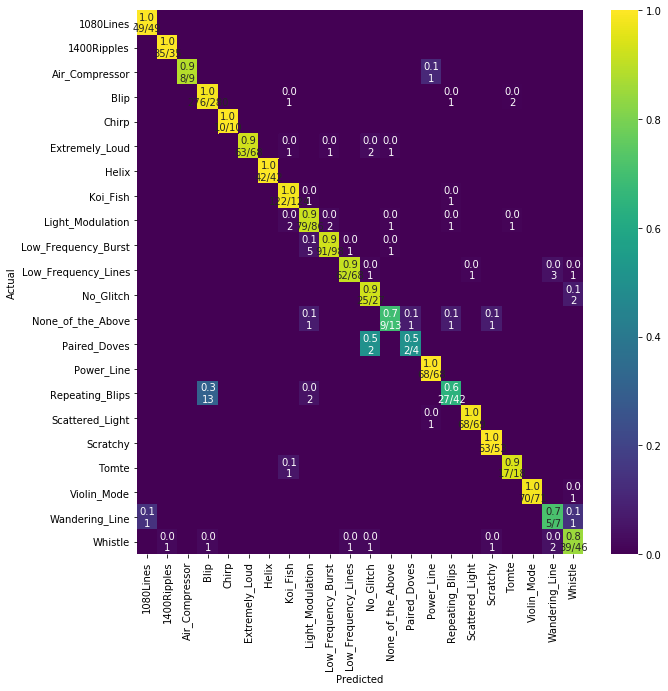

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, label, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) 
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=label, columns=label)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='viridis')
    
plot_cm(test_labels, pred_labels, glitch_set)

In [ ]:
loss,acc = model.evaluate(testX,  testY, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))